# Image Similarity Based on Color Histograms and Dominant Colors

## Idriss Khattabi - AI&DS

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist, euclidean

In [103]:
# Calculate dominant colors using K-means
def calculate_dominant_colors(image_rgb, k=18):
    # Flatten image into an array of pixels
    image_reshape = image_rgb.reshape((-1, 3))
    kmeans = KMeans(n_clusters=k, random_state=0).fit(image_reshape)
    colors = kmeans.cluster_centers_.astype(int)
    counts = np.bincount(kmeans.labels_)

    sorted_indices = np.argsort(counts)[::-1]
    sorted_colors = colors[sorted_indices]

    return sorted_colors

# Ccalculate color histograms
def calculate_histogram(image_rgb):
    histograms = []

    for i, color in enumerate(('r', 'g', 'b')):
        hist = cv2.calcHist([image_rgb], [i], None, [256], [0, 256])
        histograms.append(hist)

    return histograms

# Compute histogram similarity
def histogram_similarity(hist1, hist2):
    # Normalize histograms
    hist1 = cv2.normalize(hist1, hist1).flatten()
    hist2 = cv2.normalize(hist2, hist2).flatten()

    bhattacharyya = cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)
    chi_squared = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CHISQR)

    return bhattacharyya, chi_squared

def euclidean_similarity(colors1, colors2):
    # Calculate all pairwise distances between colors in colors1 and colors2
    distances = cdist(colors1, colors2, metric='euclidean')
    # Return the average of the minimum distances for a more representative score
    min_distances = np.min(distances, axis=1)
    return np.mean(min_distances)

def normalize_score(score, min_score, max_score):
    return (score - min_score) / (max_score - min_score)

----
## Test functions :

Text(0.5, 1.0, 'Original Image')

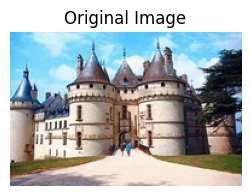

In [106]:
img1 = cv2.imread('DIR2/1472.jpg')
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
dominant_colors1 = calculate_dominant_colors(img1_rgb, k=18)

plt.figure(figsize=(6, 2))
plt.imshow(img1_rgb)
plt.axis("off")
plt.title("Original Image")

Text(0.5, 1.0, 'Dominant Colors')

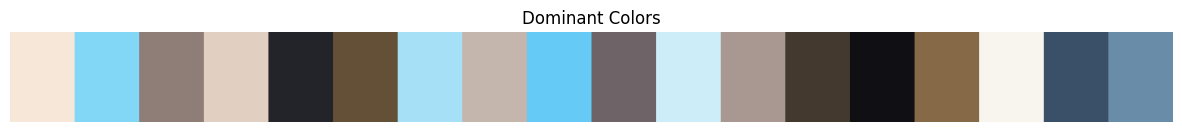

In [108]:
# Display the dominant colors
num_colors = len(dominant_colors1)
color_grid = np.zeros((70, 50 * num_colors, 3), dtype=np.uint8)
    
for i, color in enumerate(dominant_colors1):
    color_grid[:, i * 50:(i + 1) * 50] = color  # Fill each grid cell with a dominant color

plt.figure(figsize=(15, 5))
plt.imshow(color_grid)
plt.axis("off")
plt.title("Dominant Colors")

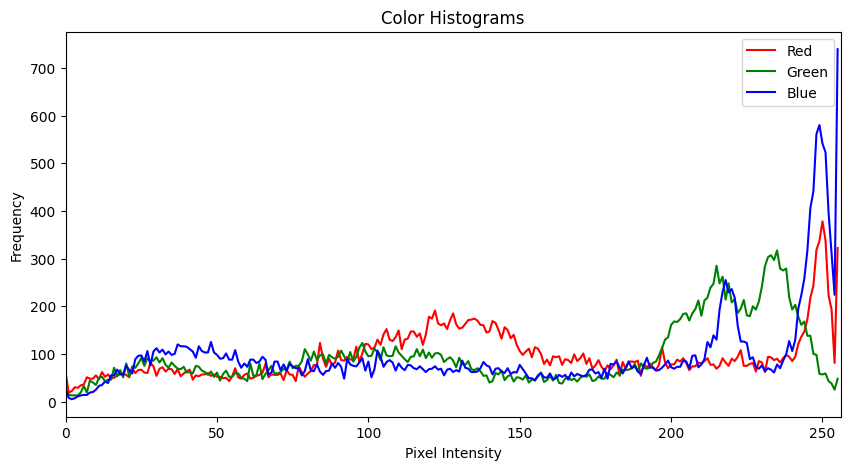

In [72]:
histograms1 = calculate_histogram(img1_rgb)

plt.figure(figsize=(10, 5))
for hist, color in zip(histograms1, ['red', 'green', 'blue']):
    plt.plot(hist, color=color)
    plt.xlim([0, 256])

plt.title("Color Histograms")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend(['Red', 'Green', 'Blue'])

---
## Compaire Images :

In [90]:
# Create comparison matrices for each score type
def create_comparison_matrices(folder_path):
    # List all image files in the directory
    files = os.listdir(folder_path)
    image_paths = [os.path.join(folder_path, fichier) for fichier in files]
    image_names = [os.path.splitext(os.path.basename(path))[0] for path in image_paths]

    # Initialize matrices to store scores
    n = len(image_paths)
    bhattacharyya_matrix = np.zeros((n, n))
    chi_squared_matrix = np.zeros((n, n))
    euclidean_matrix = np.zeros((n, n))
    global_matrix = np.zeros((n, n))

    # Compare each image with every other image
    for i in range(n):
        print('Image nbr -> ', i+1)
        image1 = cv2.imread(image_paths[i])
        image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
        hist1 = calculate_histogram(image1_rgb)
        dominant_colors1 = calculate_dominant_colors(image1_rgb)

        for j in range(i, n):
            image2 = cv2.imread(image_paths[j])
            image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
            hist2 = calculate_histogram(image2_rgb)
            dominant_colors2 = calculate_dominant_colors(image2_rgb)
            
            # Calculate histogram similarity
            bhattacharyya_list, chi_squared_list = [], []

            for k in range(3):
                bhattacharyya, chi_squared = histogram_similarity(hist1[k], hist2[k])
                bhattacharyya_list.append(bhattacharyya)
                chi_squared_list.append(chi_squared)

            bhattacharyya = np.mean(bhattacharyya_list)
            chi_squared = np.mean(chi_squared_list)
            
            
            # Calculate dominant color similarity
            euclidean_score = euclidean_similarity(dominant_colors1, dominant_colors2)
            

            # Compute normalized scores
            normalized_hist_bhattacharyya = normalize_score(bhattacharyya, 0, 1)  # 0 = perfect similarity
            normalized_hist_chi_squared = normalize_score(chi_squared, 0, 430)  # 0 = perfect similarity
            normalized_euclidean = normalize_score(euclidean_score, 0, 130)  # 0 = perfect similarity
            
             # Calculate the average of normalized scores
            global_score = ((1 - normalized_hist_bhattacharyya) +
                            (1 - normalized_hist_chi_squared) +
                            (1 - normalized_euclidean)) / 3
            

            # Update matrices symmetrically
            bhattacharyya_matrix[i][j] = bhattacharyya
            bhattacharyya_matrix[j][i] = bhattacharyya
            
            chi_squared_matrix[i][j] = chi_squared
            chi_squared_matrix[j][i] = chi_squared
            
            euclidean_matrix[i][j] = euclidean_score
            euclidean_matrix[j][i] = euclidean_score
            
            global_matrix[i][j] = global_score
            global_matrix[j][i] = global_score
        
            # print(image_paths[i], ' VS ', image_paths[j], ' ---> ', bhattacharyya, correlation, chi_squared, euclidean_score, cosine_score, global_score)
  
    return bhattacharyya_matrix, chi_squared_matrix, euclidean_matrix, global_matrix

In [91]:
folder_path = 'DVI1/'
bhattacharyya_matrix, chi_squared_matrix, euclidean_matrix, global_matrix = create_comparison_matrices(folder_path)

files = os.listdir(folder_path)
image_paths = [os.path.join(folder_path, fichier) for fichier in files]
image_names = [os.path.splitext(os.path.basename(path))[0] for path in image_paths]

Image nbr ->  1
Image nbr ->  2
Image nbr ->  3
Image nbr ->  4
Image nbr ->  5
Image nbr ->  6
Image nbr ->  7
Image nbr ->  8
Image nbr ->  9
Image nbr ->  10
Image nbr ->  11
Image nbr ->  12
Image nbr ->  13
Image nbr ->  14
Image nbr ->  15
Image nbr ->  16
Image nbr ->  17
Image nbr ->  18
Image nbr ->  19
Image nbr ->  20


Bhattacharyya Comparison Matrix:


<Axes: >

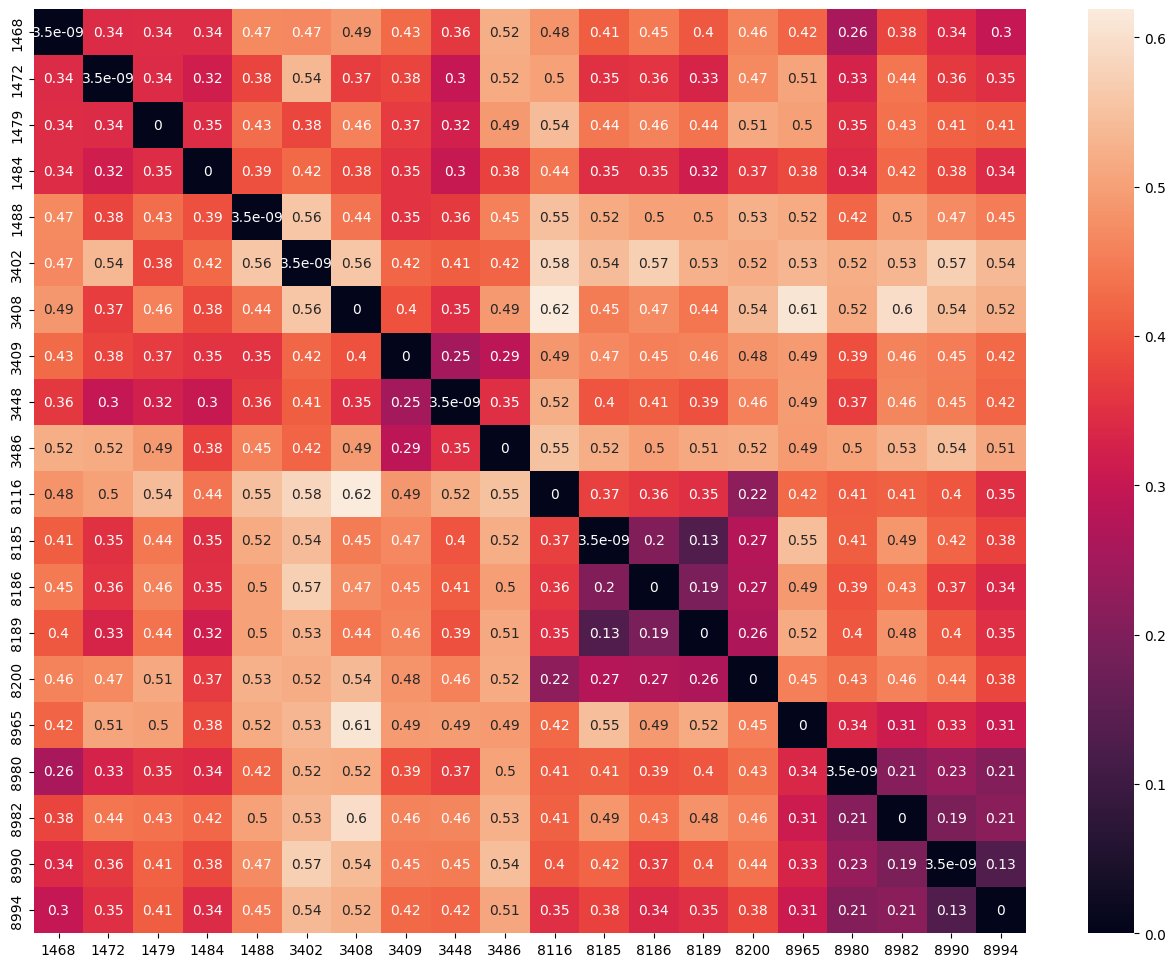

In [92]:
print("Bhattacharyya Comparison Matrix:")
plt.figure(figsize=(16, 12))
sns.heatmap(pd.DataFrame(bhattacharyya_matrix, index=image_names, columns=image_names), annot=True)

Chi Squared Comparison Matrix:


<Axes: >

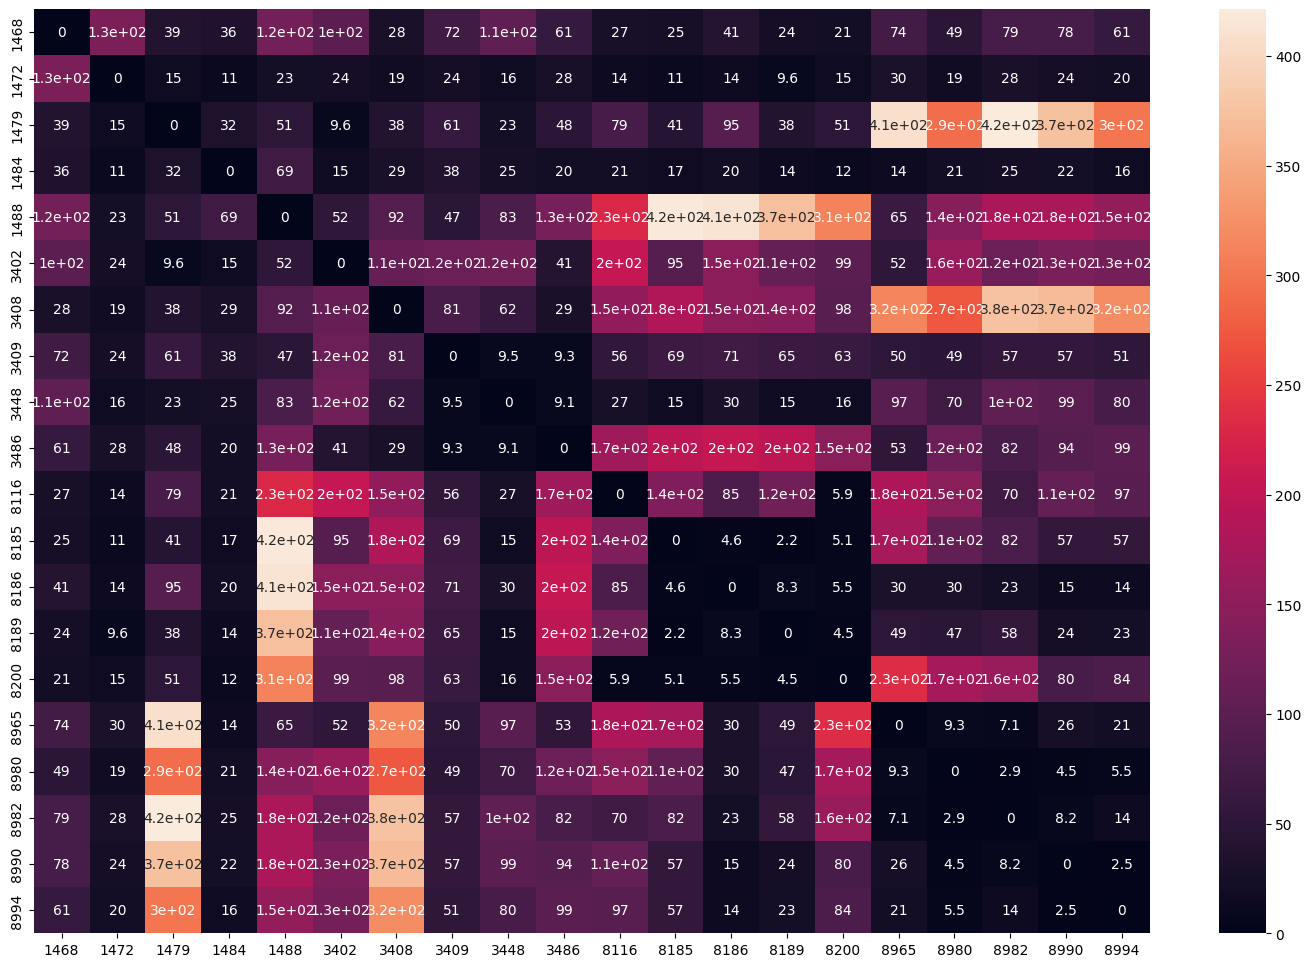

In [93]:
print("Chi Squared Comparison Matrix:")
plt.figure(figsize=(18, 12))
sns.heatmap(pd.DataFrame(chi_squared_matrix, index=image_names, columns=image_names), annot=True)

Euclidean Comparison Matrix:


<Axes: >

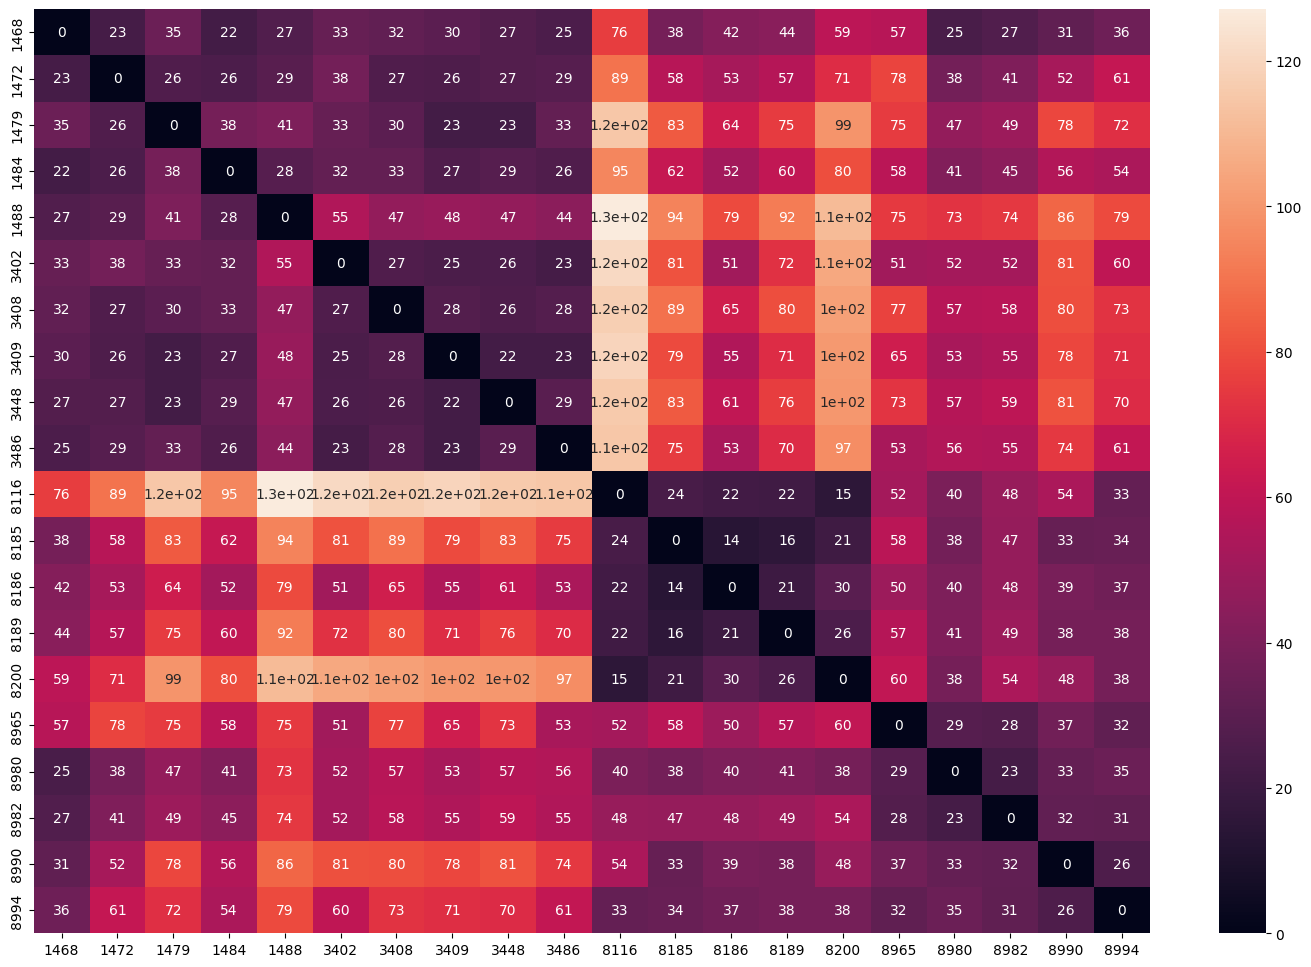

In [94]:
print("Euclidean Comparison Matrix:")
plt.figure(figsize=(18, 12))
sns.heatmap(pd.DataFrame(euclidean_matrix, index=image_names, columns=image_names), annot=True)

Global Score Comparison Matrix:


<Axes: >

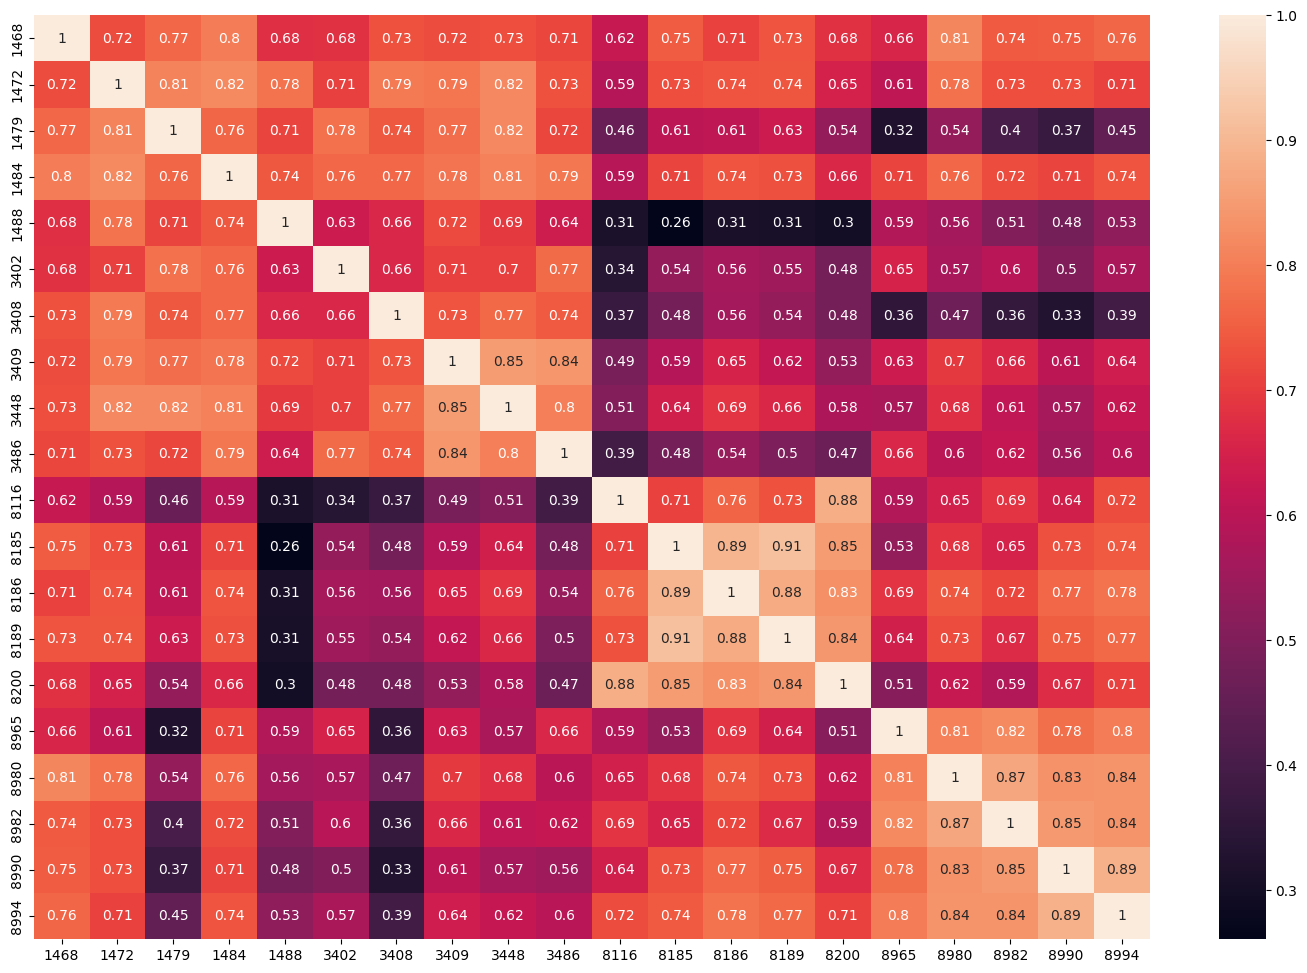

In [96]:
print("Global Score Comparison Matrix:")
plt.figure(figsize=(18, 12))
sns.heatmap(pd.DataFrame(global_matrix, index=image_names, columns=image_names), annot=True)

---
## Find Top Similar Images :

#### For each image in folder 2 we will look for 6 most similar images in folder 1

In [101]:
# Find Top 6 Similar Images for each image in DIV2
def find_top_similar_images(div1_path, div2_path, k=6):
    # Get image paths and names in DIV1
    div1_files = os.listdir(div1_path)
    div1_image_paths = [os.path.join(div1_path, file) for file in div1_files]
    div1_image_names = [os.path.splitext(os.path.basename(path))[0] for path in div1_image_paths]

    # Get image paths and names in DIV2
    div2_files = os.listdir(div2_path)
    div2_image_paths = [os.path.join(div2_path, file) for file in div2_files]
    div2_image_names = [os.path.splitext(os.path.basename(path))[0] for path in div2_image_paths]

    # Dictionary to store the top k similar images in DIV1 for each image in DIV2
    top_similar_images = {}

    # Compare each image in DIV2 with each image in DIV1
    for div2_image_path, div2_image_name in zip(div2_image_paths, div2_image_names):
        # Load and process the DIV2 image
        div2_image = cv2.imread(div2_image_path)
        div2_image_rgb = cv2.cvtColor(div2_image, cv2.COLOR_BGR2RGB)
        div2_hist = calculate_histogram(div2_image_rgb)
        div2_dominant_colors = calculate_dominant_colors(div2_image_rgb)

        similarities = []

        for div1_image_path, div1_image_name in zip(div1_image_paths, div1_image_names):
            # Load and process the DIV1 image
            div1_image = cv2.imread(div1_image_path)
            div1_image_rgb = cv2.cvtColor(div1_image, cv2.COLOR_BGR2RGB)
            div1_hist = calculate_histogram(div1_image_rgb)
            div1_dominant_colors = calculate_dominant_colors(div1_image_rgb)

            # Compute histogram similarity
            bhattacharyya_list, chi_squared_list = [], []
            for i in range(3):
                bhattacharyya, chi_squared = histogram_similarity(div2_hist[i], div1_hist[i])
                bhattacharyya_list.append(bhattacharyya)
                chi_squared_list.append(chi_squared)

            bhattacharyya = np.mean(bhattacharyya_list)
            chi_squared = np.mean(chi_squared_list)

            # Calculate dominant color similarity
            euclidean_score = euclidean_similarity(div2_dominant_colors, div1_dominant_colors)

            # Compute normalized scores
            normalized_hist_bhattacharyya = normalize_score(bhattacharyya, 0, 1)
            normalized_hist_chi_squared = normalize_score(chi_squared, 0, 430)
            normalized_euclidean = normalize_score(euclidean_score, 0, 130)
            
            # Calculate global score
            global_score = ((1 - normalized_hist_bhattacharyya) +
                            (1 - normalized_hist_chi_squared) +
                            (1 - normalized_euclidean)) / 3

            # Append the image name and score to similarities list
            similarities.append((div1_image_name, global_score))

        # Sort the similarities by global score and get the top k
        top_k_similar = sorted(similarities, key=lambda x: x[1], reverse=True)[:k]
        top_similar_images[div2_image_name] = top_k_similar

    return top_similar_images

In [82]:
# Function to display the image
def display_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb

Top 6 similar images in DIV1 for 1472:
  1484 with global score 0.8200
  3448 with global score 0.8177
  1479 with global score 0.8067
  1468 with global score 0.8058
  3408 with global score 0.7939
  3409 with global score 0.7877



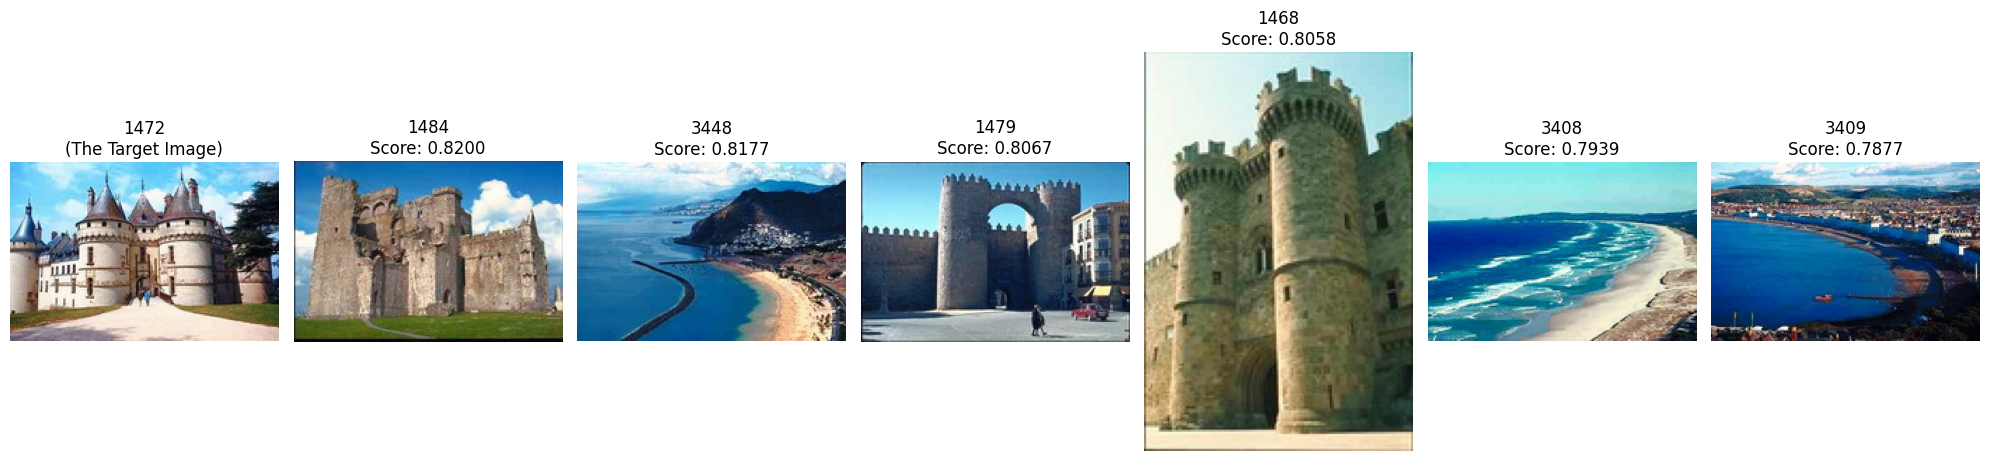

Top 6 similar images in DIV1 for 3486:
  3409 with global score 0.8279
  3402 with global score 0.7817
  3448 with global score 0.7693
  1484 with global score 0.7503
  1479 with global score 0.6761
  1488 with global score 0.6739



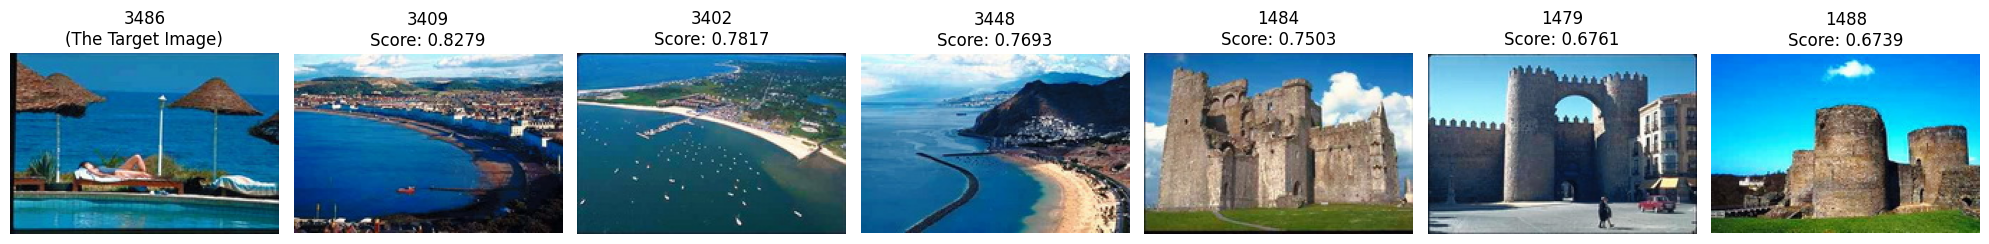

Top 6 similar images in DIV1 for 8189:
  8185 with global score 0.8988
  8186 with global score 0.8811
  8200 with global score 0.8425
  8116 with global score 0.7935
  8994 with global score 0.7683
  8990 with global score 0.7500



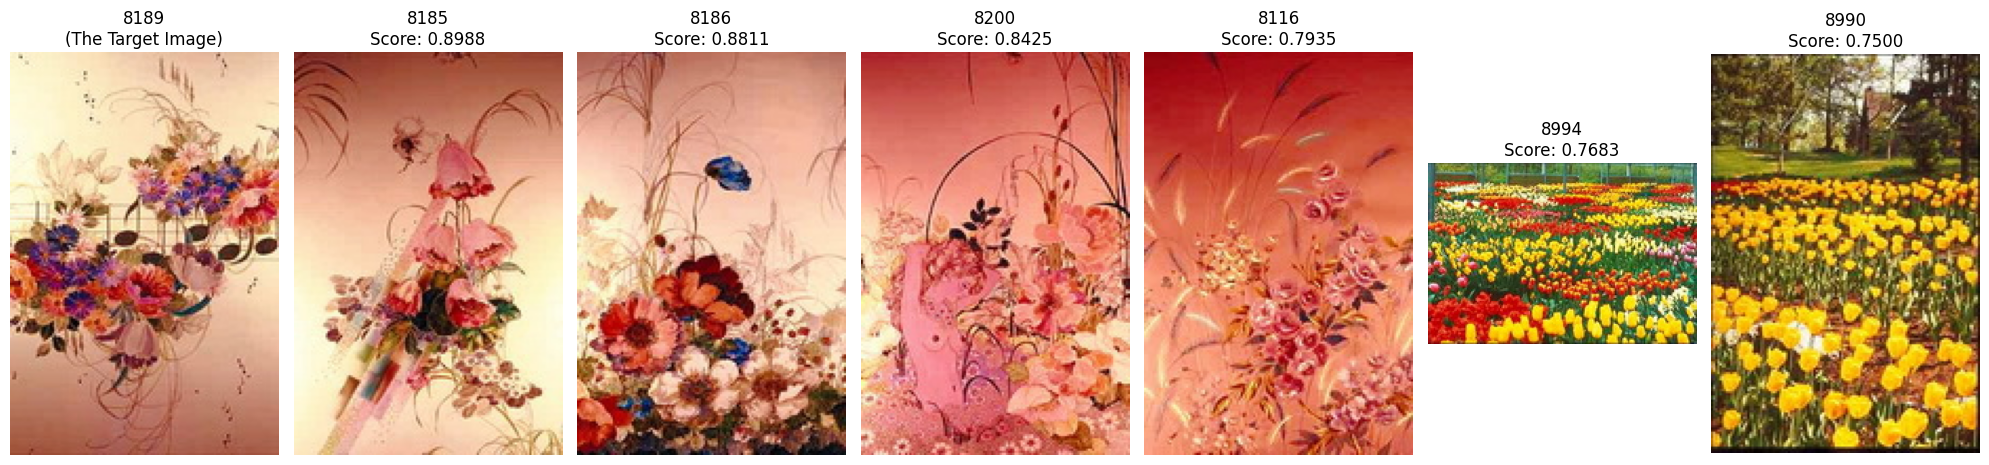

Top 6 similar images in DIV1 for 8965:
  8982 with global score 0.8202
  8980 with global score 0.8063
  8994 with global score 0.8001
  8990 with global score 0.7751
  1468 with global score 0.7027
  1484 with global score 0.6996



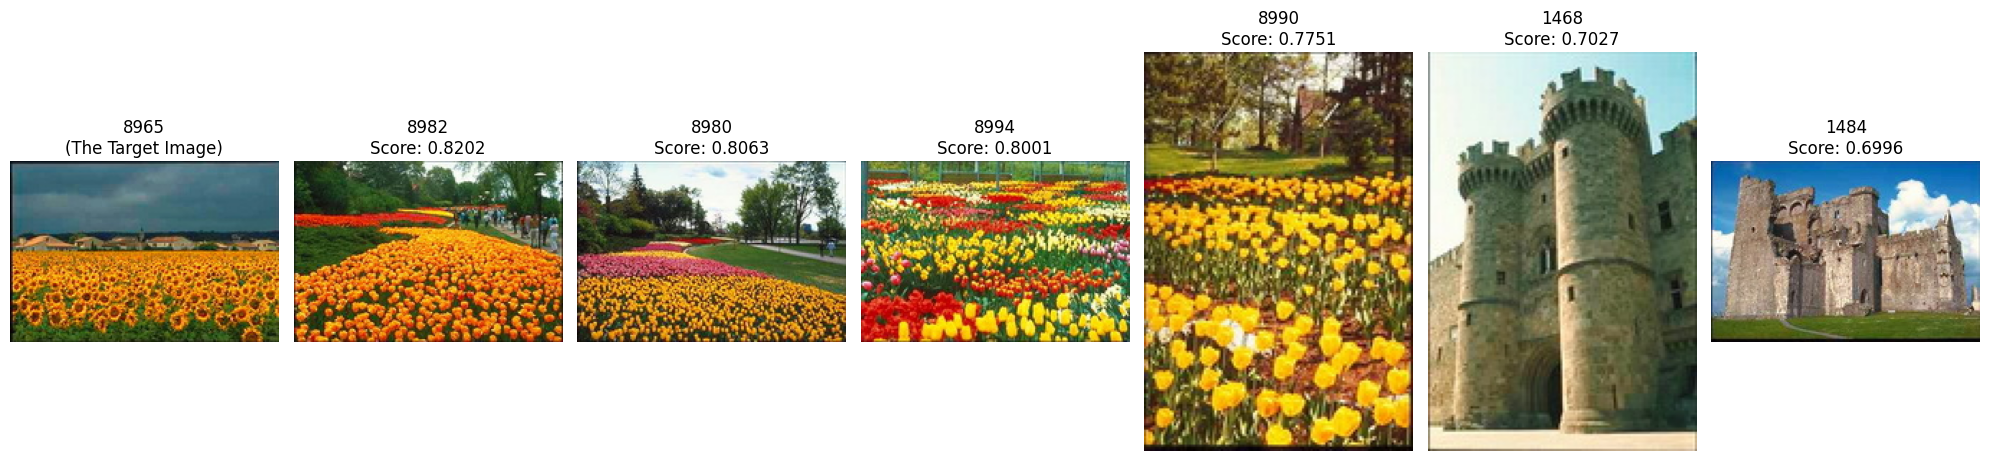

In [102]:
div1_path = 'DIR1/'
div2_path = 'DIR2/'
top_similar_images = find_top_similar_images(div1_path, div2_path)

# Display the top 6 similar images for each image in DIV2
for div2_image, similarities in top_similar_images.items():
    div2_image_path = os.path.join(div2_path, div2_image + '.jpg')
    print(f"Top 6 similar images in DIV1 for {div2_image}:")
    
    for div1_image, score in similarities:
        print(f"  {div1_image} with global score {score:.4f}")
    print()
    
    # Set up the subplot to display the DIV2 image with its top 6 matches
    fig, axes = plt.subplots(1, 7, figsize=(20, 5))
    
    # Display the DIV2 image on the left
    div2_image_rgb = display_image(div2_image_path)
    if div2_image_rgb is not None:
        axes[0].imshow(div2_image_rgb)
        axes[0].set_title(f"{div2_image}\n(The Target Image)")
        axes[0].axis("off")
    
    # Display each of the top 6 similar images from DIV1
    for idx, (div1_image, score) in enumerate(similarities[:6]):
        div1_image_path = os.path.join(div1_path, div1_image + '.jpg')
        div1_image_rgb = display_image(div1_image_path)
        if div1_image_rgb is not None:
            axes[idx + 1].imshow(div1_image_rgb)
            axes[idx + 1].set_title(f"{div1_image}\nScore: {score:.4f}")
            axes[idx + 1].axis("off")
    
    plt.tight_layout()
    plt.show()